In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Return Period')

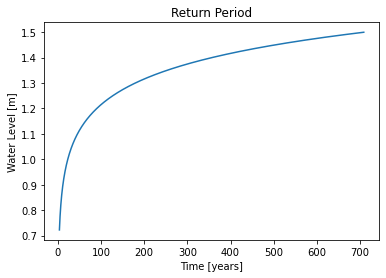

In [2]:
a = 0.145329158
b = 0.546101744
return_period_f = (lambda x: math.exp((x-b)/a))

x_min = 0.722
x_max = 1.5
N = 10000
water_level = np.linspace(x_min,x_max,N)

prob_failure_f = (lambda x: 0.9/0.7*x+(0.1-0.9/0.7*0.8))

plt.plot([return_period_f(x) for x in water_level],water_level)
plt.ylabel('Water Level [m]')
plt.xlabel('Time [years]')
plt.title('Return Period')

In [3]:
import pandas as pd
df = pd.read_csv(r'return_period.csv', sep=';',header=0)
X = np.array([[i] for i in df['return period'].values])
y = df['intensity'].values

from pygam import LinearGAM, s, f

gam = LinearGAM(s(0, n_splines=len(X))).gridsearch(X, y)
gam.summary()

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.8777
Link Function:                     IdentityLink Log Likelihood:                                  -890.1439
Number of Samples:                           11 AIC:                                             1792.0432
                                                AICc:                                            1811.6563
                                                GCV:                                                0.0126
                                                Scale:                                              0.0032
                                                Pseudo R-Squared:                                   0.9679
Feature Function                  Lam

<ipython-input-3-4e55d3968d13>:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


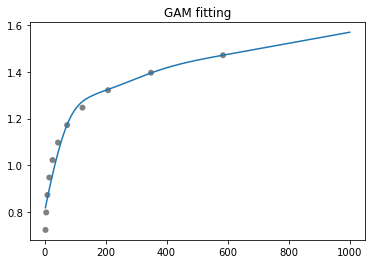

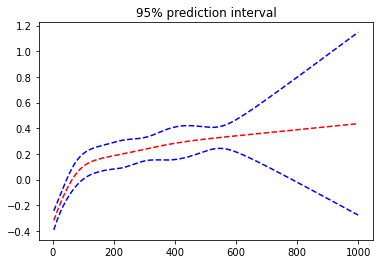

In [5]:
XX = np.linspace(3,1000,1000)

pdep, confi = gam.partial_dependence(term=0, X=XX, width=0.95)

plt.figure()
plt.plot(XX, gam.predict(XX))
plt.scatter(X, y, facecolor='gray', edgecolors='none')
plt.title('GAM fitting')

plt.figure()
plt.plot(XX, confi, c='b', ls='--')
plt.plot(XX, pdep, 'r--')
plt.title('95% prediction interval')

plt.show()

Text(0.5, 1.0, 'CDF of Hazard Intensity')

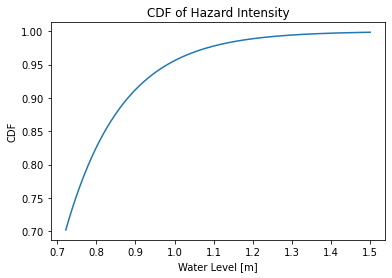

In [6]:
CDF_water_level_f = (lambda x: 1-1/return_period_f(x))

plt.plot(water_level, [CDF_water_level_f(x) for x in water_level])
plt.ylabel('CDF')
plt.xlabel('Water Level [m]')
plt.title('CDF of Hazard Intensity')
#plt.show()

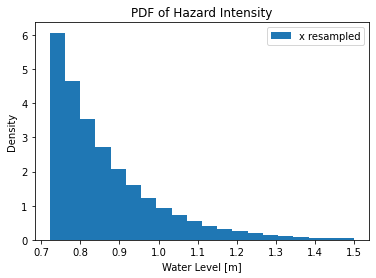

In [7]:
from pynverse import inversefunc
inv_CDF_water_level_f = inversefunc(CDF_water_level_f)

CDF_samples = np.linspace(CDF_water_level_f(x_min),CDF_water_level_f(x_max),N)
water_level_resampled = [inv_CDF_water_level_f(cdf) for cdf in CDF_samples]

hist1 = plt.hist(np.hstack(water_level_resampled), bins=20 ,density=True, label='x resampled')

plt.ylabel('Density')
plt.xlabel('Water Level [m]')
plt.title('PDF of Hazard Intensity')
plt.legend()



Text(0.5, 1.0, 'PDF of the Probability of Equipment Failure')

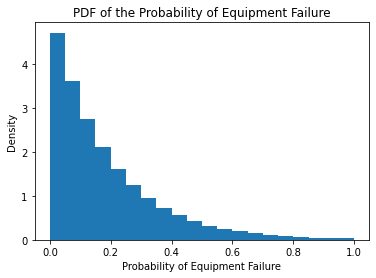

In [8]:
z = [prob_failure_f(x) for x in water_level_resampled]

plt.hist(z, density=True, bins=20)

plt.ylabel('Density')
plt.xlabel('Probability of Equipment Failure')
plt.title('PDF of the Probability of Equipment Failure')

In [9]:
from sklearn.cluster import KMeans
import pandas as pd

data = np.column_stack((np.array(z),np.zeros(len(z))))
n_clusters = 4

kmeans = KMeans(init="random", n_clusters=n_clusters,
                n_init=100, max_iter=300).fit(data)

maxs, mins, nh, var, mean, std = [], [], [], [], [], []
for cluster in range(n_clusters):
    maxs.append(np.array(z)[np.where(kmeans.labels_==cluster)].max())
    mins.append(np.array(z)[np.where(kmeans.labels_==cluster)].min())
    nh.append(np.count_nonzero(kmeans.labels_==cluster))
    var.append(np.var(np.array(z)[np.where(kmeans.labels_==cluster)]))
    std.append(np.std(np.array(z)[np.where(kmeans.labels_==cluster)]))
    mean.append(np.mean(np.array(z)[np.where(kmeans.labels_==cluster)]))

labels = list(range(n_clusters))
results = [[i1,i2,i3,i4,i5,i6,i7] for (i1,i2,i3,i4,i5,i6,i7) in zip(labels, mins, maxs, nh, var, std, mean)]

df = pd.DataFrame(results, columns=['cluster label', 'lower boundary', 'upper boundary', 'Nh', 'var', 'std', 'mean'])
df.sort_values(by=['lower boundary'])

,cluster label,lower boundary,upper boundary,Nh,var,std,mean
2,2,-0.000286,0.128811,5013,0.001357,0.036836,0.056890
1,1,0.128848,0.296463,2982,0.002252,0.047451,0.200295
0,0,0.296554,0.537324,1487,0.004462,0.066798,0.391790
3,3,0.537655,1.000000,518,0.013541,0.116365,0.682158


Text(0.5, 1.0, 'Culuster using kmeans; k=4')

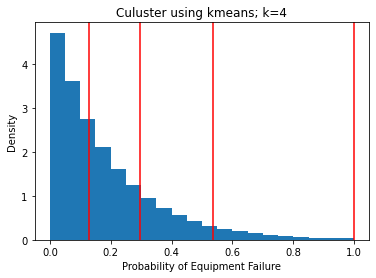

In [10]:
plt.hist(z, density=True, bins=20)
for b in maxs:
    plt.axvline(x = b, color = 'r')

plt.ylabel('Density')
plt.xlabel('Probability of Equipment Failure')
plt.title('Culuster using kmeans; k=4')

Text(0.5, 1.0, 'Culuster using Jenks natural breaks; k=4')

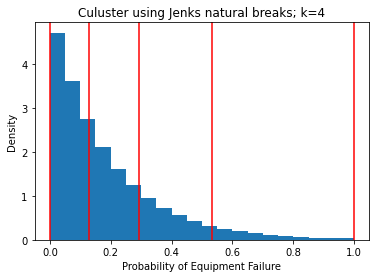

In [11]:
import jenkspy as jp
bins=jp.jenks_breaks(z, n_classes=n_clusters)

plt.hist(z, density=True, bins=20)
for b in bins:
    plt.axvline(x = b, color = 'r')

plt.ylabel('Density')
plt.xlabel('Probability of Equipment Failure')
plt.title('Culuster using Jenks natural breaks; k=4')

In [12]:
maxs, mins, nh, var, mean, std = [], [], [], [], [], []
for i in range(n_clusters):
    data_i = np.array(z)[np.where((z>= bins[i]) & (z<bins[i+1]))]

    maxs.append(data_i.max())
    mins.append(data_i.min())
    nh.append(np.count_nonzero(data_i))
    var.append(np.var(data_i))
    std.append(np.std(data_i))
    mean.append(np.mean(data_i))

labels = list(range(n_clusters))
results = [[i1,i2,i3,i4,i5,i6,i7] for (i1,i2,i3,i4,i5,i6,i7) in zip(labels, mins, maxs, nh, var, std, mean)]

df = pd.DataFrame(results, columns=['cluster label', 'lower boundary', 'upper boundary', 'Nh', 'var', 'std', 'mean'])
df.sort_values(by=['lower boundary'])

,cluster label,lower boundary,upper boundary,Nh,var,std,mean
0,0,-0.000286,0.127038,4965,0.001321,0.036342,0.056203
1,1,0.127075,0.292946,2991,0.002207,0.046976,0.197902
2,2,0.293035,0.533077,1513,0.004437,0.066611,0.388055
3,3,0.533401,0.996111,530,0.013555,0.116425,0.677958


In [13]:
df['var'].sum()

0.02151917760896271

In [14]:
# dictionary of lists  
dict = {'z': z}  
df = pd.DataFrame(dict) 
# saving the dataframe 
df.to_csv('z_data.csv')

In [ ]:
bins

In [ ]:
CDF_samples